### NN Model For Line Quality

Author: Jerry Chen

Neural network to predict line quality metrics

Input Parameters In Order
* Extruder Flowrate - Q (uL/min)
* Gantry Travel Speed - V<sub>g</sub> (mm/min)
* Layer Height (mm)

Output Parameters In Order
* Average Line Width - l<sub>w</sub>(μm)
* Average Line Height - l<sub>h</sub> (μm)

In [1]:
# Importing Useful libraries
import matplotlib.pylab as plt
import torch
import numpy as np

%matplotlib widget

torch.manual_seed(42)

use_cuda = True
device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'

# Class to represent dataset


class lineDataSet():

    def __init__(self):
        filename = "clean_data.csv"
        # Loading the csv file from the folder path
        # First row is data labels so delete
        data1 = np.loadtxt(filename, delimiter=',',
                           dtype=np.float32, skiprows=1)

        # First 3 column are inputs
        # Last 2 are columns are outputs
        # ['Q (uL/min)', 'Vg (mm/min)', 'Layer Height (mm)', 'Average Line Width (μm)', 'Average Line Height (μm)']

        # Zero center and normalize input and output data
        self.x = data1[:, [0, 1]]  # Shape Nx2
        self.input_mean = np.mean(self.x, axis=0)
        self.input_std = np.std(self.x, axis=0)
        self.x = torch.from_numpy((self.x-self.input_mean)/self.input_std)

        self.y = data1[:, [3, 4]]  # Shape Nx2
        self.output_mean = np.mean(self.y, axis=0)
        self.output_std = np.std(self.y, axis=0)
        self.y = torch.from_numpy((self.y-self.output_mean)/self.output_std)

        self.n_samples = data1.shape[0]

    # support indexing such that dataset[i] can
    # be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


dataset = lineDataSet()

first_data = dataset[0]
inputs, outputs = first_data
print(inputs, outputs)
print(inputs*dataset.input_std+dataset.input_mean,
      outputs*dataset.output_std+dataset.output_mean)

# Expected Output
# tensor([8.0976e+01, 1.9202e+03) tensor([364.2700,  78.4050]


tensor([-1.5394,  1.5381]) tensor([-1.8517, -1.8783])
tensor([  80.9764, 1920.2285]) tensor([364.2700,  78.4050])


/home/jerry/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import torch.nn as nn

# Network model


class Network(nn.Module):
    def __init__(self, channels=1):  # default grayscale
        super().__init__()
        # self.batch1 = nn.BatchNorm1d(2)
        # BEST 2-6 6-2 2-2
        self.linear1 = nn.Linear(in_features=2, out_features=6)
        self.linear2 = nn.Linear(in_features=6, out_features=6)
        # self.linear3 = nn.Linear(in_features=6, out_features=4)
        # self.linear4 = nn.Linear(in_features=2, out_features=2)
        # self.linear5 = nn.Linear(in_features=2, out_features=2)
        # self.linear6 = nn.Linear(in_features=2, out_features=2)
        # self.linear7 = nn.Linear(in_features=2, out_features=2)
        self.out = nn.Linear(in_features=6, out_features=2)

    def forward(self, t):
        # t=self.batch1(t)
        t = self.linear1(t)
        t = torch.relu(t)
        t = self.linear2(t)
        t = torch.relu(t)
        # t = self.linear3(t)
        # t = torch.relu(t)
        # t = self.linear4(t)
        # t = torch.relu(t)
        # t = torch.tanh(t)
        # More layers generate more pronounced seperation
        # t = self.linear2(t)
        # t = F.tanh(t)
        t = self.out(t)
        return t


step_size= 0.01 batch_size= 5 shuffle= True 

Epoch 0 Prediction: 0.15 -0.11 Actual: -0.77 -0.28
Epoch 1 Prediction: -0.12 -0.16 Actual: -0.77 -0.28
Epoch 2 Prediction: -0.44 -0.46 Actual: -0.77 -0.28
Epoch 3 Prediction: -0.62 -0.60 Actual: -0.77 -0.28
Epoch 4 Prediction: -0.53 -0.46 Actual: -0.77 -0.28
Epoch 5 Prediction: -0.54 -0.45 Actual: -0.77 -0.28
Epoch 6 Prediction: -0.66 -0.55 Actual: -0.77 -0.28
Epoch 7 Prediction: -0.60 -0.54 Actual: -0.77 -0.28
Epoch 8 Prediction: -0.54 -0.48 Actual: -0.77 -0.28
Epoch 9 Prediction: -0.67 -0.60 Actual: -0.77 -0.28
Epoch 10 Prediction: -0.52 -0.49 Actual: -0.77 -0.28
Epoch 11 Prediction: -0.57 -0.52 Actual: -0.77 -0.28
Epoch 12 Prediction: -0.56 -0.46 Actual: -0.77 -0.28
Epoch 13 Prediction: -0.59 -0.48 Actual: -0.77 -0.28
Epoch 14 Prediction: -0.59 -0.49 Actual: -0.77 -0.28
Epoch 15 Prediction: -0.49 -0.48 Actual: -0.77 -0.28
Epoch 16 Prediction: -0.58 -0.48 Actual: -0.77 -0.28
Epoch 17 Prediction: -0.57 -0.45 Actual: -0.77 -0.28
Epoch 18 Pr

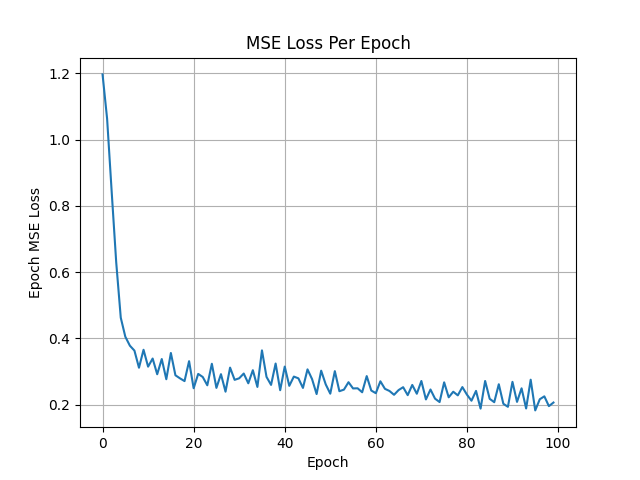

In [3]:
# Training
def train(step_size, batch_size=5, shuffle=False, num_epochs=10, plot_loss=False):
    # Loading in data
    dataset = lineDataSet()
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size])

    dsets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

    # Data loading - batch_size and shuffle
    dset_loader = {x: torch.utils.data.DataLoader(
        dsets[x], batch_size=batch_size, shuffle=shuffle) for x in ['train', 'val', 'test']}

    # Start network
    network = Network()
    if device == "cuda":
        print("Using CUDA")
        network.cuda()

    # Training
    print('step_size=', step_size, 'batch_size=',
          batch_size, 'shuffle=', shuffle, '\n')

    optimizer = torch.optim.Adam(network.parameters(), lr=step_size)

    best_epoch = 0
    best_epoch_loss = np.inf
    epoch_losses = []
    epoch_percent_error = []
    for epoch in range(num_epochs):
        for input_val, out_val in dset_loader['train']:
            network.train(True)    # Set model to training mode

            if device == "cuda":
                input_val = input_val.cuda()
                out_val = out_val.cuda()

            optimizer.zero_grad()    # Zero the gradients of the network weights prior to backprop

            # Forward pass through the network - Shape batch x output
            preds = network(input_val)

            # Compute the minibatch loss with mean squared error
            minibatch_loss = torch.nn.functional.mse_loss(preds, out_val)
            minibatch_loss.backward()

            optimizer.step()

        # Validation time
        network.train(False)    # Set model to evaluation mode
        network.eval()

        input_val = val_dataset[:][0]
        out_val = val_dataset[:][1]

        if device == "cuda":
            input_val = input_val.cuda()
            out_val = out_val.cuda()

        preds = network(input_val)

        avg_epoch_loss = torch.nn.functional.mse_loss(preds, out_val)

        # Mean percent error extra divide by 2 because 2 outputs for each data point
        avg_epoch_percent_error = 100 * \
            torch.sum(torch.abs((preds-out_val)/out_val))/(2*val_size)

        epoch_percent_error.append(
            avg_epoch_percent_error.cpu().detach().numpy())

        epoch_losses.append(avg_epoch_loss.cpu().detach().numpy())

        # print(f"epoch:{epoch}\t avg_val_MSE_error:{avg_epoch_loss}")
        print("Epoch {} Prediction: {:.2f} {:.2f} Actual: {:.2f} {:.2f}".format(
            epoch, preds[0][0].item(), preds[0][1].item(),
            out_val[0][0].item(), out_val[0][1].item()))

        if avg_epoch_loss < best_epoch_loss:
            best_epoch_loss = avg_epoch_loss
            best_epoch = epoch
            torch.save(network.state_dict(), f'best_model.pth')

    # Test set time
    network.train(False)    # Set model to evaluation mode
    network.eval()

    input_val = val_dataset[:][0]
    out_val = val_dataset[:][1]

    if device == "cuda":
        input_val = input_val.cuda()
        out_val = out_val.cuda()

    preds = network(input_val)

    test_loss = torch.nn.functional.mse_loss(preds, out_val)

    # Mean percent error extra divide by 2 because 2 outputs for each data point
    test_percent_error = 100 * \
        torch.sum(torch.abs((preds-out_val)/out_val))/(2*val_size)

    print("Best epoch {}, val loss {:.3f}, test loss {:.3f}, test pse {:.3f}".format(
        best_epoch, best_epoch_loss, test_loss, test_percent_error))
    print(f"Train size {train_size}, Val size {val_size}, Test size {test_size}")
    if plot_loss:
        """
        fig, ax = plt.subplots(1, 2)
        ax[0].plot([i for i in range(num_epochs)], epoch_losses)
        ax[0].set(xlabel='Epoch', ylabel='Epoch MSE Loss',
                  title='MSE Loss Per Epoch')
        ax[0].grid()

        ax[1].plot([i for i in range(num_epochs)], epoch_percent_error)
        ax[1].set(xlabel='Epoch', ylabel='Percent Error',
                  title='Percent Error Per Epoch')
        ax[1].grid()
        """
        fig = plt.figure()
        ax = plt.axes()
        ax.plot([i for i in range(num_epochs)], epoch_losses)
        ax.set(xlabel='Epoch', ylabel='Epoch MSE Loss',
                  title='MSE Loss Per Epoch')
        ax.grid()

        plt.savefig("Epoch Loss.png", dpi=300)
        plt.show()

    return network


lr_list = [0.1, 0.01, 0.001]
batch_size_list = [10, 100, 1000]
shuffle_list = [True, False]

# hyperparameter grid search
# for param in product(lr_list, batch_size_list, shuffle_list):


best_network = train(0.01, shuffle=True, num_epochs=100, plot_loss=True)


### Plotting down below

Network(
  (linear1): Linear(in_features=2, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=2, bias=True)
)


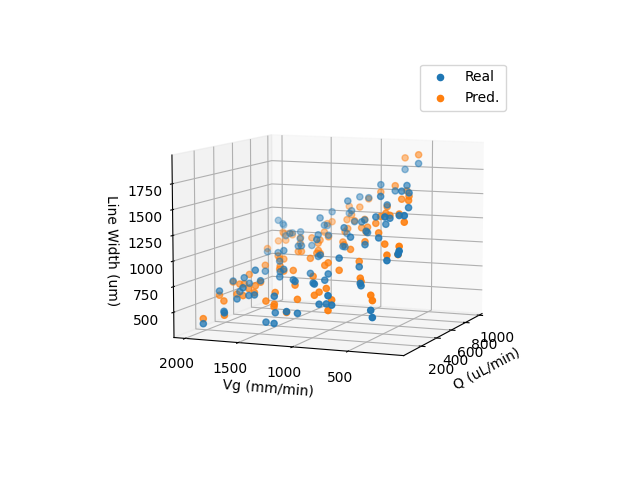

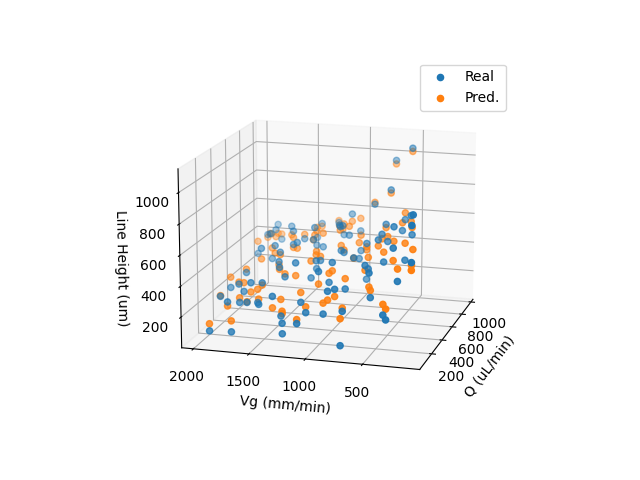

In [7]:
import pandas as pd

filename = "clean_data.csv"

df = pd.read_csv(filename)

# print(df.columns)
# ['Q (uL/min)', 'Vg (mm/min)', 'Layer Height (mm)', 'Average Line Width (μm)', 'Average Line Height (μm)']

# Loading data from source
Q = df.loc[:, 'Q (uL/min)'].values

Vg = df.loc[:, 'Vg (mm/min)'].values

lw = df.loc[:, 'Average Line Width (μm)'].values

lh = df.loc[:, 'Average Line Height (μm)'].values


# Neural network
dataset = lineDataSet()

best_network = Network()
best_network.load_state_dict(torch.load('best_model.pth'))

print(best_network)
"""
for m in best_network.modules():
    if isinstance(m, nn.Linear):
        print(m.state_dict()['weight'])
        print(m.state_dict()['bias'])
"""

best_network.train(False)
best_network.eval()

network = best_network.cpu()
pred = network(dataset[:][0])

lw_pred = pred[:, 0] * \
    dataset.output_std[0] + dataset.output_mean[0]
lw_pred = lw_pred.detach().numpy()

lh_pred = pred[:, 1] * \
    dataset.output_std[1] + dataset.output_mean[1]
lh_pred = lh_pred.detach().numpy()


# Width
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter(Q, Vg, lw, label="Real")
ax.scatter(Q, Vg, lw_pred, label="Pred.")

ax.set_zlabel('Line Width (um)')

ax.set_xlabel('Q (uL/min)')
ax.set_ylabel('Vg (mm/min)')

ax.view_init(elev=8, azim=-158)
ax.legend()
plt.savefig("NN_Q_Vg_Width.png", dpi=300)
plt.show()

# Height
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter(Q, Vg, lh, label="Real")
ax.scatter(Q, Vg, lh_pred, label="Pred.")

ax.set_zlabel('Line Height (um)')

ax.set_xlabel('Q (uL/min)')
ax.set_ylabel('Vg (mm/min)')

ax.view_init(elev=15, azim=-164)
ax.legend()
plt.savefig("NN_Q_Vg_Height.png", dpi=300)
plt.show()


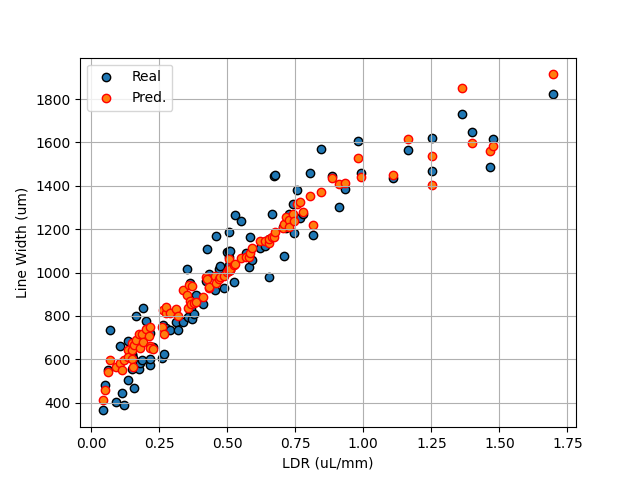

R-squared Line Width: 0.9157788372279279


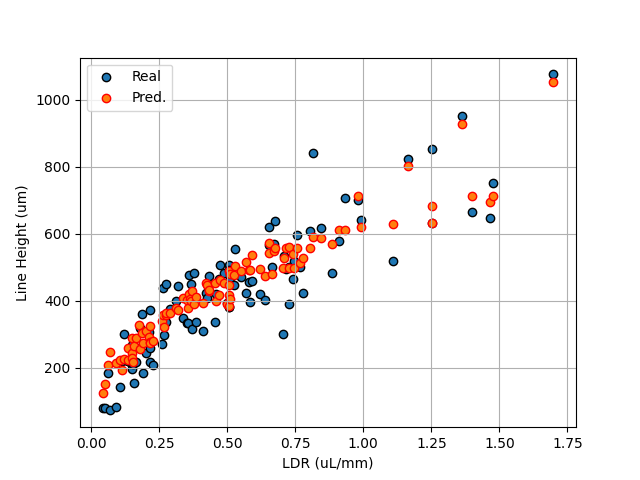

R-squared Line Height: 0.8523023042360597


In [8]:
from sklearn.metrics import r2_score

ldr = Q/Vg  # (ul/mm)

# LDR against width
fig = plt.figure()
ax = plt.axes()

ax.scatter(ldr, lw, edgecolor='k', label="Real")

ax.scatter(ldr, lw_pred, edgecolor='r', label="Pred.")

ax.set_xlabel('LDR (uL/mm)')
ax.set_ylabel('Line Width (um)')
ax.legend()
ax.grid()
plt.savefig("NN_LDR_Width_unmarked.png", dpi=300)
plt.show()

# print the result
print("R-squared Line Width:", r2_score(lw, lw_pred))

# LDR against height
fig = plt.figure()
ax = plt.axes()

ax.scatter(ldr, lh, edgecolor='k', label="Real")

ax.scatter(ldr, lh_pred, edgecolor='r', label="Pred.")

ax.set_xlabel('LDR (uL/mm)')
ax.set_ylabel('Line Height (um)')
ax.legend()
ax.grid()
plt.savefig("NN_LDR_Height_unmarked.png", dpi=300)
plt.show()

# print the result
print("R-squared Line Height:", r2_score(lh, lh_pred))
